In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

path = 'C:/Users/Suraj/GitHub/biosignals/files/10s_eyes_open_at_desk.json'

# Load the JSON file
with open(path) as f:
    eeg_data = json.load(f)

# Extract timestamps and data
timestamps = np.array(eeg_data['data']['timestamps'])
channels_data = np.array(eeg_data['data']['data'])

# Check the initial shapes
print("Initial Timestamps shape:", timestamps.shape)
print("Initial EEG data shape:", channels_data.shape)

# Reshape the data
# Each timestamp has 16 voltage samples, so we need to flatten the data
flattened_data = channels_data.flatten()

# Generate detailed timestamps for each sample within the 62.5ms window
sampling_rate = 256  # Hz
window_size = 62.5 / 1000  # 62.5ms in seconds
num_samples_per_window = 16

# Create a detailed timestamp array
detailed_timestamps = np.repeat(timestamps, num_samples_per_window) + \
    np.tile(np.linspace(0, window_size, num_samples_per_window, endpoint=False), len(timestamps))

# Check the final shapes
print("Flattened EEG data shape:", flattened_data.shape)
print("Detailed Timestamps shape:", detailed_timestamps.shape)

Initial Timestamps shape: (169,)
Initial EEG data shape: (8, 2704)
Flattened EEG data shape: (21632,)
Detailed Timestamps shape: (2704,)


In [39]:
channel_names = [
      'CP3', 'C3',
      'F5',  'PO3',
      'PO4', 'F6',
      'C4',  'CP4'
    ]

eeg_data['data']['channelNames'] = channel_names

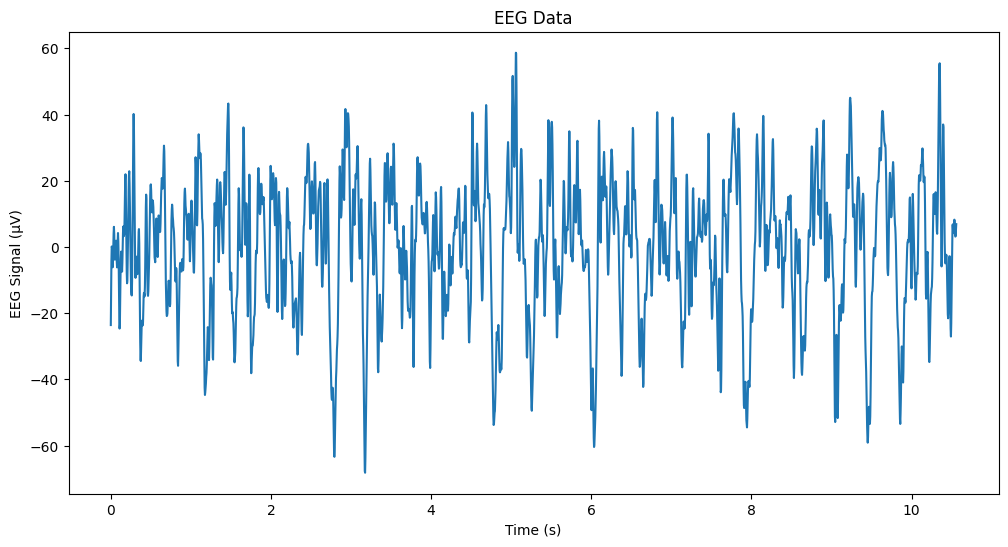

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(detailed_timestamps, eeg_data['data']['data'][7])
plt.xlabel('Time (s)')
plt.ylabel('EEG Signal (µV)')
plt.title('EEG Data')
plt.show()

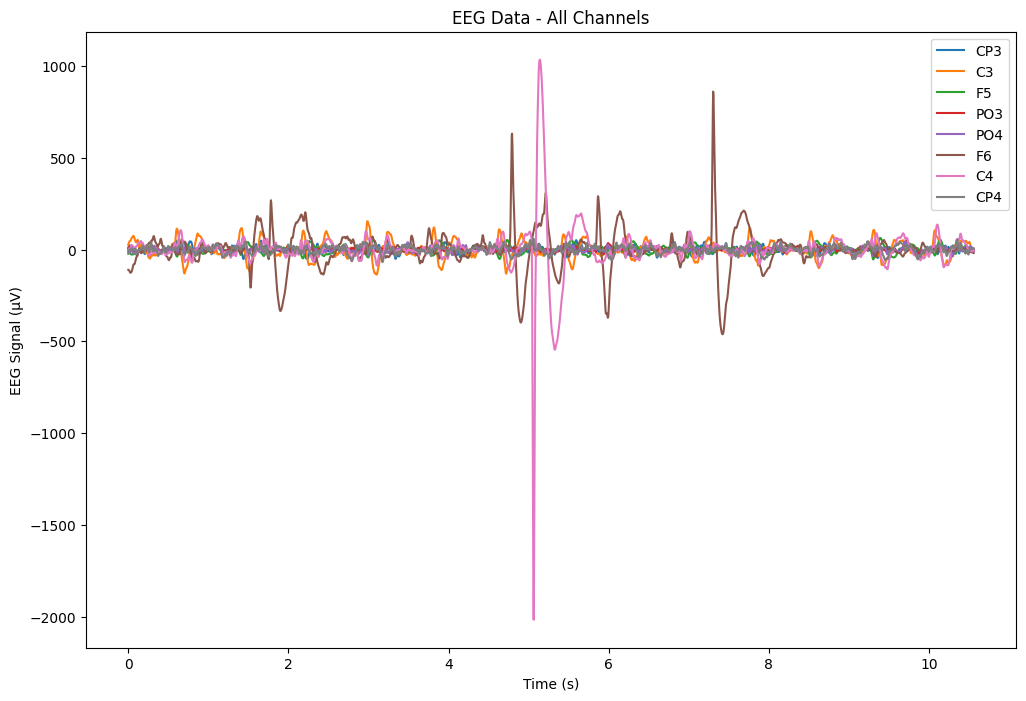

In [4]:
channels = eeg_data['data']['data']

plt.figure(figsize=(12, 8))
for i, channel_name in enumerate(channel_names):
    plt.plot(detailed_timestamps, channels[i], label=channel_name)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal (µV)')
plt.title('EEG Data - All Channels')
plt.legend(loc='upper right')
plt.show()

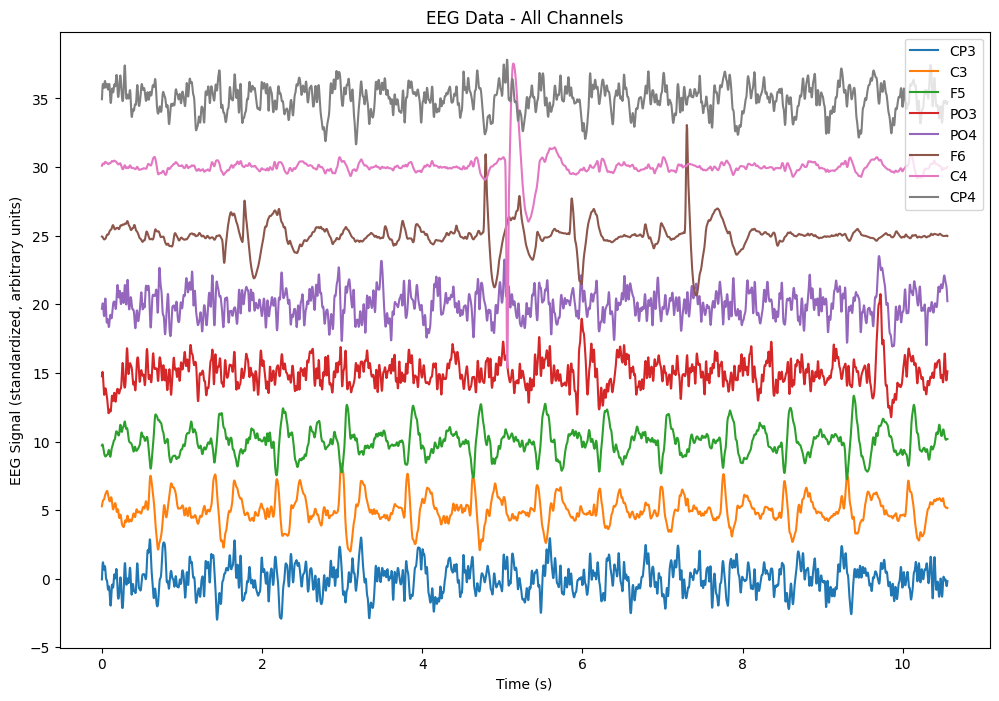

In [5]:
from scipy.signal import butter, filtfilt

# Generate detailed timestamps
num_samples_per_window = 16
window_size = 62.5 / 1000  # 62.5ms in seconds
detailed_timestamps = np.repeat(timestamps, num_samples_per_window) + \
    np.tile(np.linspace(0, window_size, num_samples_per_window, endpoint=False), len(timestamps))

# Function to apply bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Apply bandpass filter to each channel
lowcut = 0.5
highcut = 50.0
filtered_data = np.array([bandpass_filter(channel, lowcut, highcut, sampling_rate) for channel in channels_data])

# Standardize the data
standardized_data = (filtered_data - np.mean(filtered_data, axis=1, keepdims=True)) / np.std(filtered_data, axis=1, keepdims=True)

# Plot all channels on the same graph
plt.figure(figsize=(12, 8))
for i, channel_name in enumerate(channel_names):
    plt.plot(detailed_timestamps, standardized_data[i] + i*5, label=channel_name)  # Offset each channel for clarity

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal (standardized, arbitrary units)')
plt.title('EEG Data - All Channels')
plt.legend(loc='upper right')
plt.show()

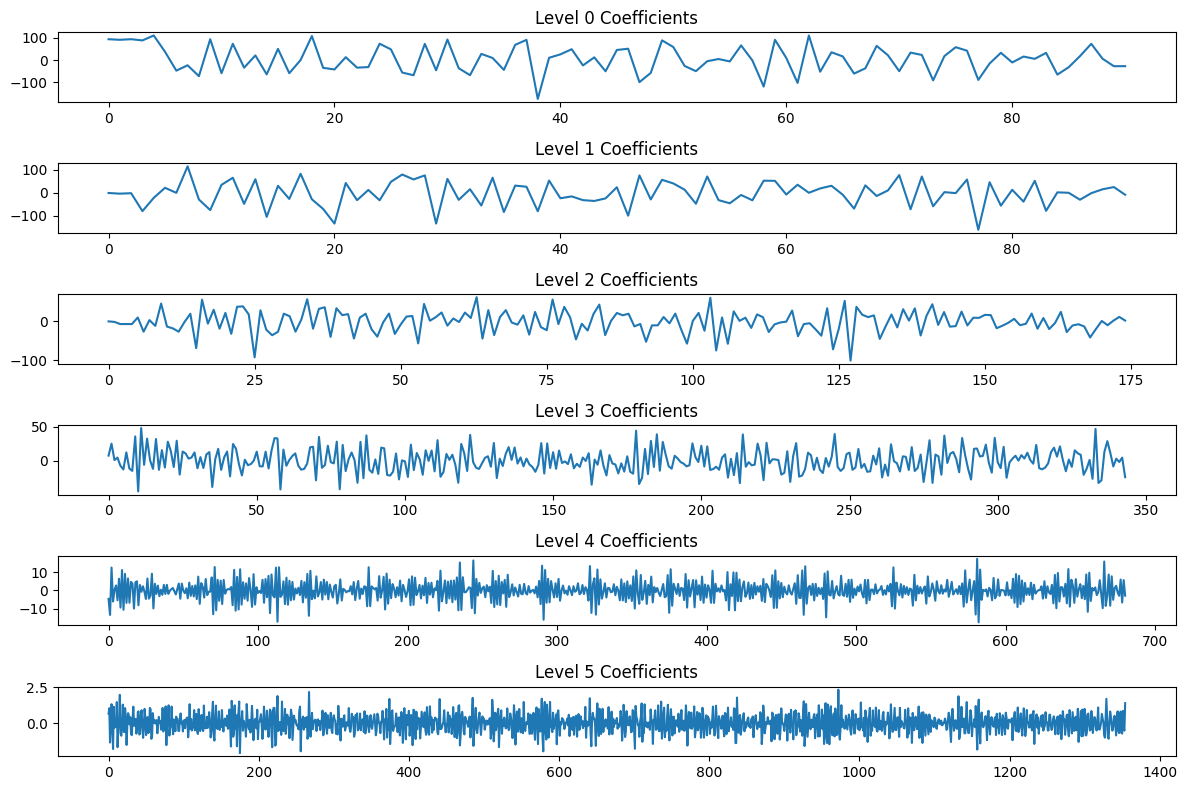

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pywt

first_channel_data = channels_data[0]

# Perform Discrete Wavelet Transform on the first channel
wavelet = 'db4'
coeffs = pywt.wavedec(first_channel_data, wavelet, level=5)

# Plot the DWT coefficients
plt.figure(figsize=(12, 8))
for i, coeff in enumerate(coeffs):
    plt.subplot(len(coeffs), 1, i + 1)
    plt.plot(coeff)
    plt.title(f'Level {i} Coefficients')

plt.tight_layout()
plt.show()

In [7]:
# Function to reconstruct signal up to a specific level
def reconstruct_up_to_level(coeffs, wavelet, level):
    coeffs_to_reconstruct = coeffs[:level+1] + [None]*(len(coeffs)-level-1)
    return pywt.waverec(coeffs_to_reconstruct, wavelet)

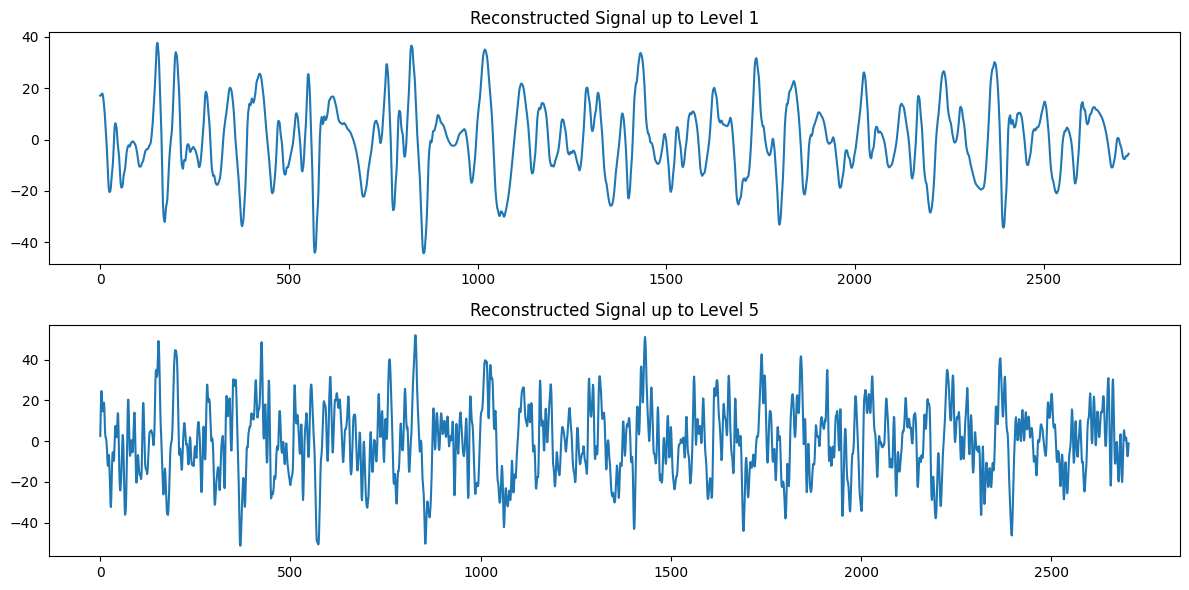

In [8]:
lvl_1 = 1
lvl_2 = 5

# Reconstruct signals up to specific levels (for example, levels 3 and 4)
reconstructed_signal_up_to_level_3 = reconstruct_up_to_level(coeffs, wavelet, lvl_1)
reconstructed_signal_up_to_level_4 = reconstruct_up_to_level(coeffs, wavelet, lvl_2)

# Plot the reconstructed signals
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(reconstructed_signal_up_to_level_3)
plt.title(f'Reconstructed Signal up to Level {lvl_1}')

plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal_up_to_level_4)
plt.title(f'Reconstructed Signal up to Level {lvl_2}')

plt.tight_layout()
plt.show()

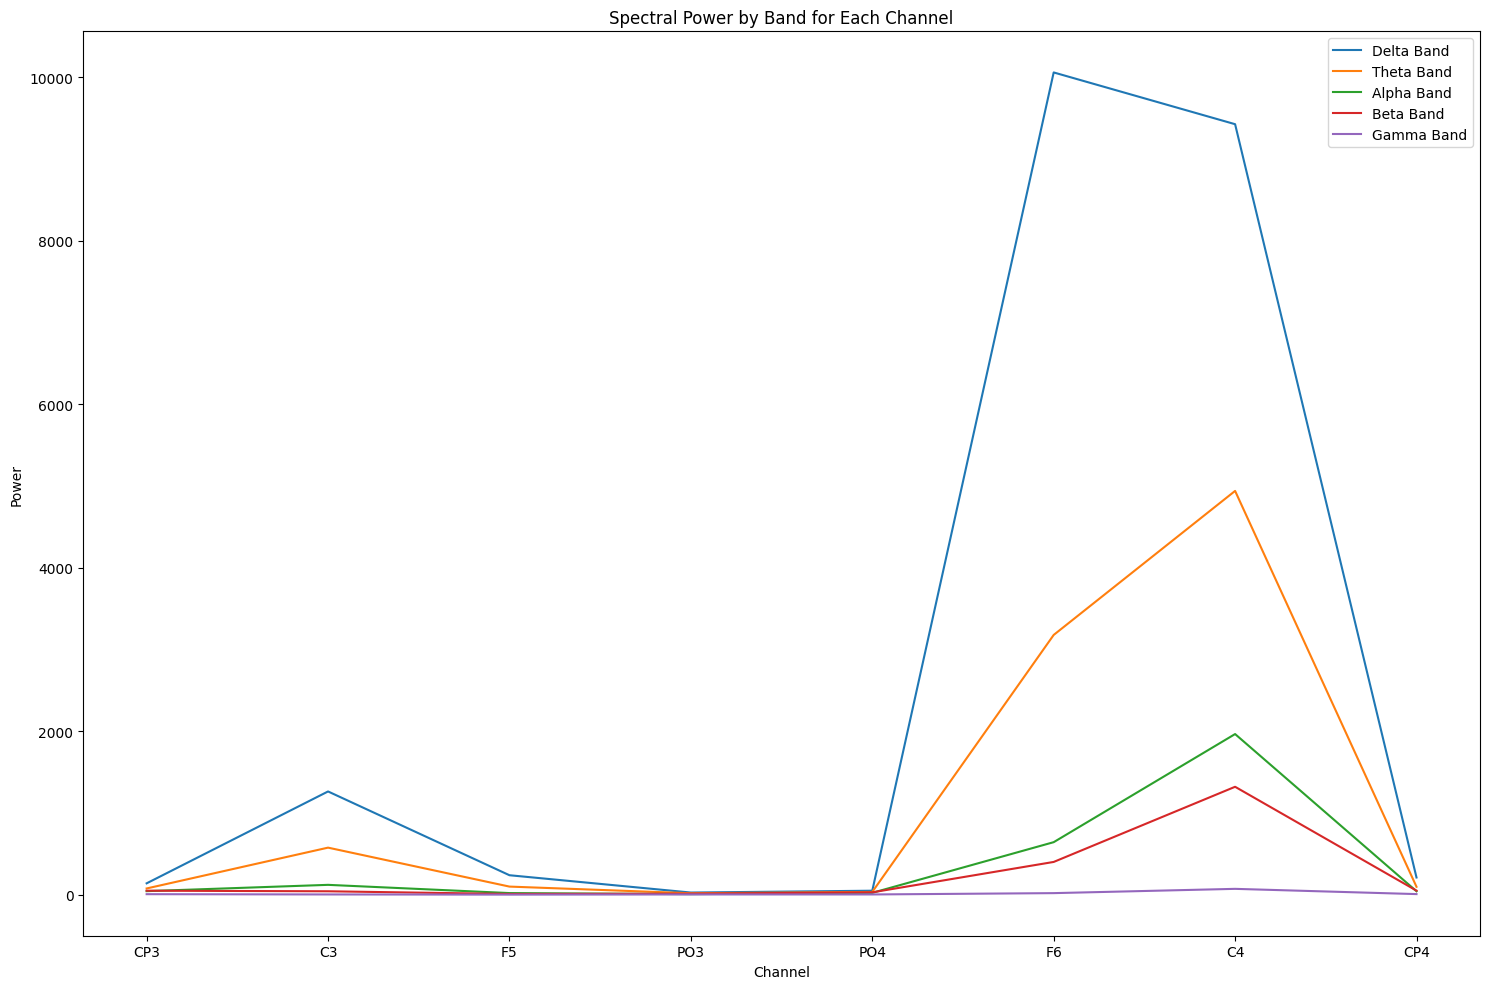

In [9]:
from scipy.signal import welch


# Define frequency bands
freq_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 50)
}

# Function to calculate spectral power for each band
def bandpower(data, sf, band, window_sec=4, relative=False):
    band = np.asarray(band)
    low, high = band

    freqs, psd = welch(data, sf, nperseg=window_sec*sf)

    idx_band = np.logical_and(freqs >= low, freqs <= high)
    band_power = np.trapz(psd[idx_band], freqs[idx_band])

    if relative:
        band_power /= np.trapz(psd, freqs)
    
    return band_power

# Calculate band powers for each channel
band_powers = {band: [] for band in freq_bands}
for i, channel_data in enumerate(channels_data):
    for band, (low, high) in freq_bands.items():
        power = bandpower(channel_data, sampling_rate, [low, high])
        band_powers[band].append(power)

# Plot the band powers for each channel
plt.figure(figsize=(15, 10))
for band, powers in band_powers.items():
    plt.plot(channel_names, powers, label=f'{band} Band')

plt.xlabel('Channel')
plt.ylabel('Power')
plt.title('Spectral Power by Band for Each Channel')
plt.legend()
plt.tight_layout()
plt.show()

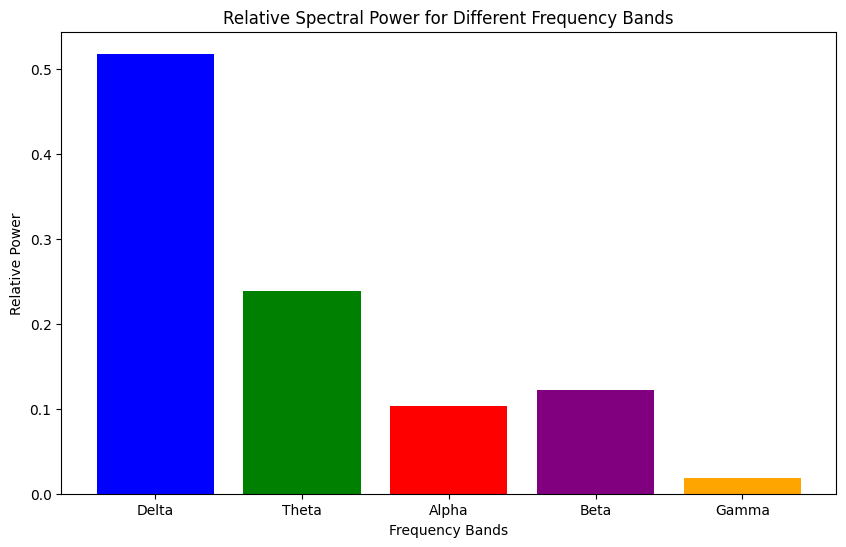

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Assuming channels_data and sampling_rate are already defined
# For demonstration, let's take the first channel
first_channel_data = channels_data[7]

# Define frequency bands
freq_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 50)
}

# Function to calculate spectral power for each band
def bandpower(data, sf, band, window_sec=4, relative=False):
    band = np.asarray(band)
    low, high = band

    freqs, psd = welch(data, sf, nperseg=window_sec*sf)

    idx_band = np.logical_and(freqs >= low, freqs <= high)
    band_power = np.trapz(psd[idx_band], freqs[idx_band])

    if relative:
        band_power /= np.trapz(psd, freqs)
    
    return band_power

# Calculate relative band powers for the first channel
relative_band_powers = []
total_power = bandpower(first_channel_data, sampling_rate, [0.5, 50])
for band, (low, high) in freq_bands.items():
    power = bandpower(first_channel_data, sampling_rate, [low, high])
    relative_power = power / total_power
    relative_band_powers.append(relative_power)

# Plot the relative band powers as a bar chart
bands = list(freq_bands.keys())
plt.figure(figsize=(10, 6))
plt.bar(bands, relative_band_powers, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Frequency Bands')
plt.ylabel('Relative Power')
plt.title('Relative Spectral Power for Different Frequency Bands')
plt.show()


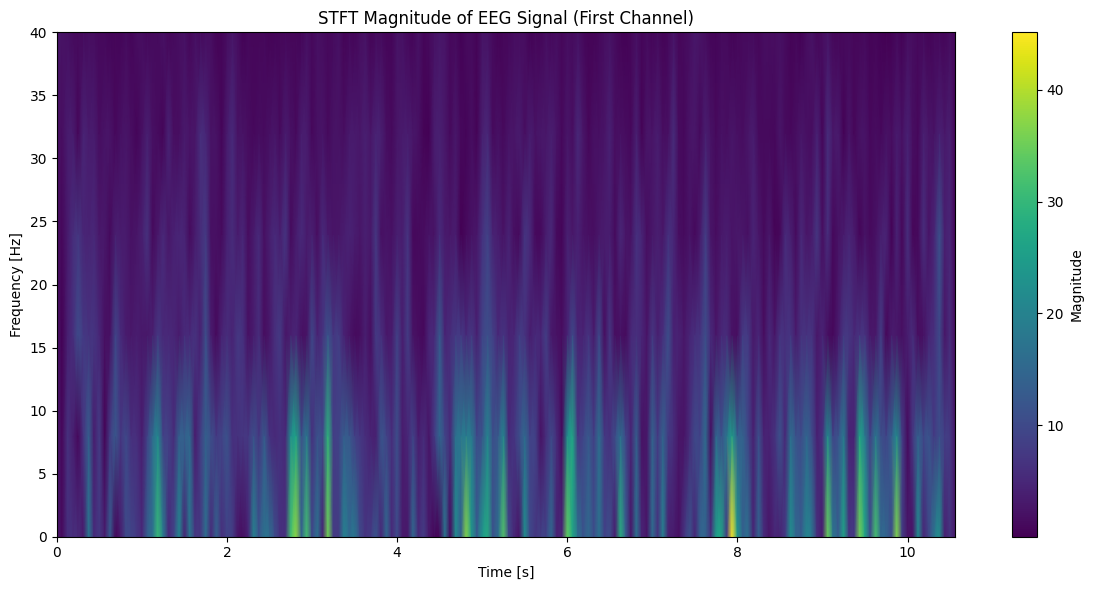

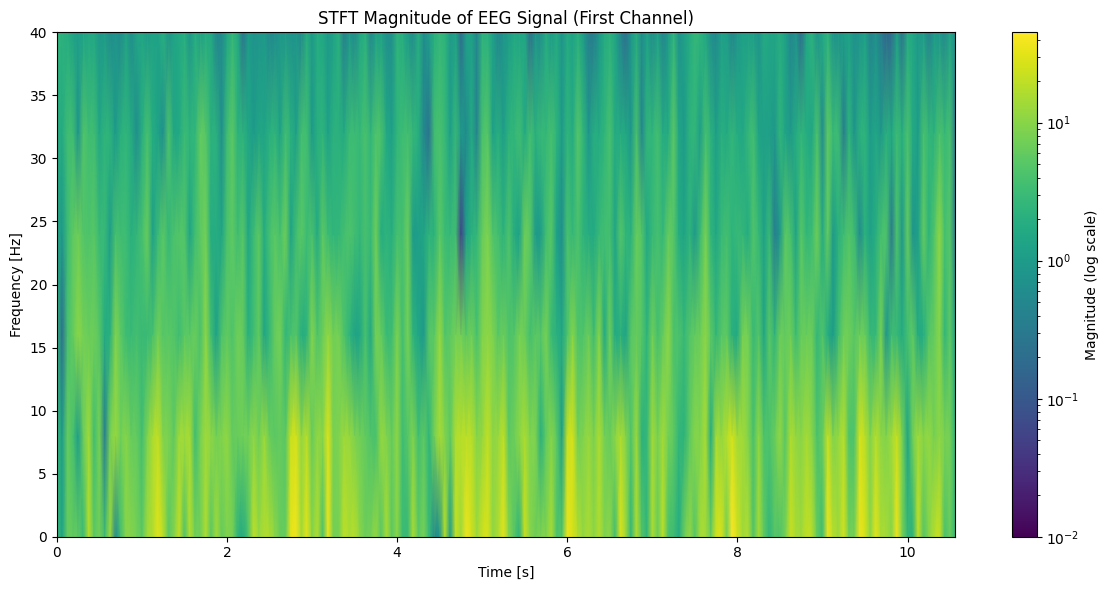

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from matplotlib.colors import LogNorm

# Assuming 'channels_data' contains the EEG data for each channel
# and we have already loaded the data as in previous steps
first_channel_data = channels_data[7]
sampling_rate = 256  # Hz

# Parameters for STFT
window_size = 32  # Number of samples per window
overlap = 16  # Number of samples to overlap

# Compute STFT
f, t, Zxx = stft(first_channel_data, fs=sampling_rate, window='hann', nperseg=window_size, noverlap=overlap)

# Plot the STFT
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude of EEG Signal (First Channel)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude')
plt.ylim(0, 40) 
plt.tight_layout()
plt.show()

# Plot the STFT with logarithmic scaling
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', norm=LogNorm(vmin=0.01, vmax=np.abs(Zxx).max()))
plt.title('STFT Magnitude of EEG Signal (First Channel)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude (log scale)')
plt.ylim(0, 40)  # Limit the y-axis to 0-40 Hz
plt.tight_layout()
plt.show()

c:\users\suraj\github\biosignals\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\users\suraj\github\biosignals\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


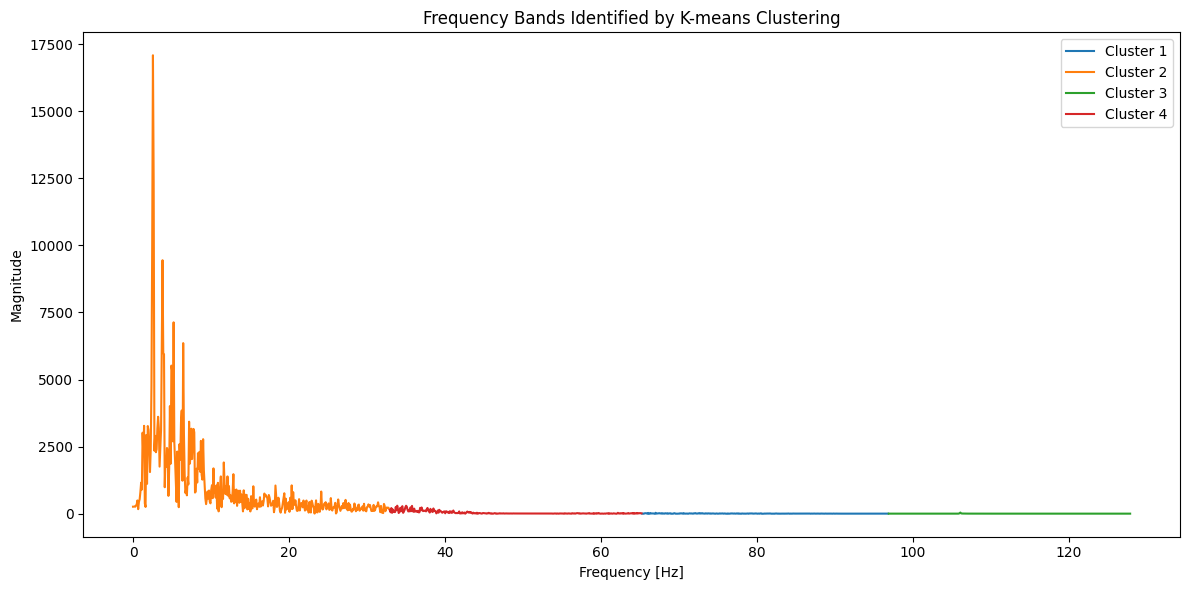

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from sklearn.cluster import KMeans

# Assuming 'channels_data' contains the EEG data for each channel
# and we have already loaded the data as in previous steps
first_channel_data = channels_data[2]
sampling_rate = 256  # Hz
n_samples = len(first_channel_data)

# Compute the Fourier Transform
frequencies = fftfreq(n_samples, d=1/sampling_rate)
fft_values = np.abs(fft(first_channel_data))

# Select only the positive frequencies
positive_frequencies = frequencies[:n_samples // 2]
positive_fft_values = fft_values[:n_samples // 2]

# Reshape for clustering
X = positive_frequencies.reshape(-1, 1)

# Apply k-means clustering
kmeans = KMeans(n_clusters=4)  # Number of clusters can be adjusted
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(12, 6))
for i in range(4):
    cluster_indices = labels == i
    plt.plot(positive_frequencies[cluster_indices], positive_fft_values[cluster_indices], label=f'Cluster {i+1}')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency Bands Identified by K-means Clustering')
plt.legend()
plt.tight_layout()
plt.show()


c:\users\suraj\github\biosignals\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


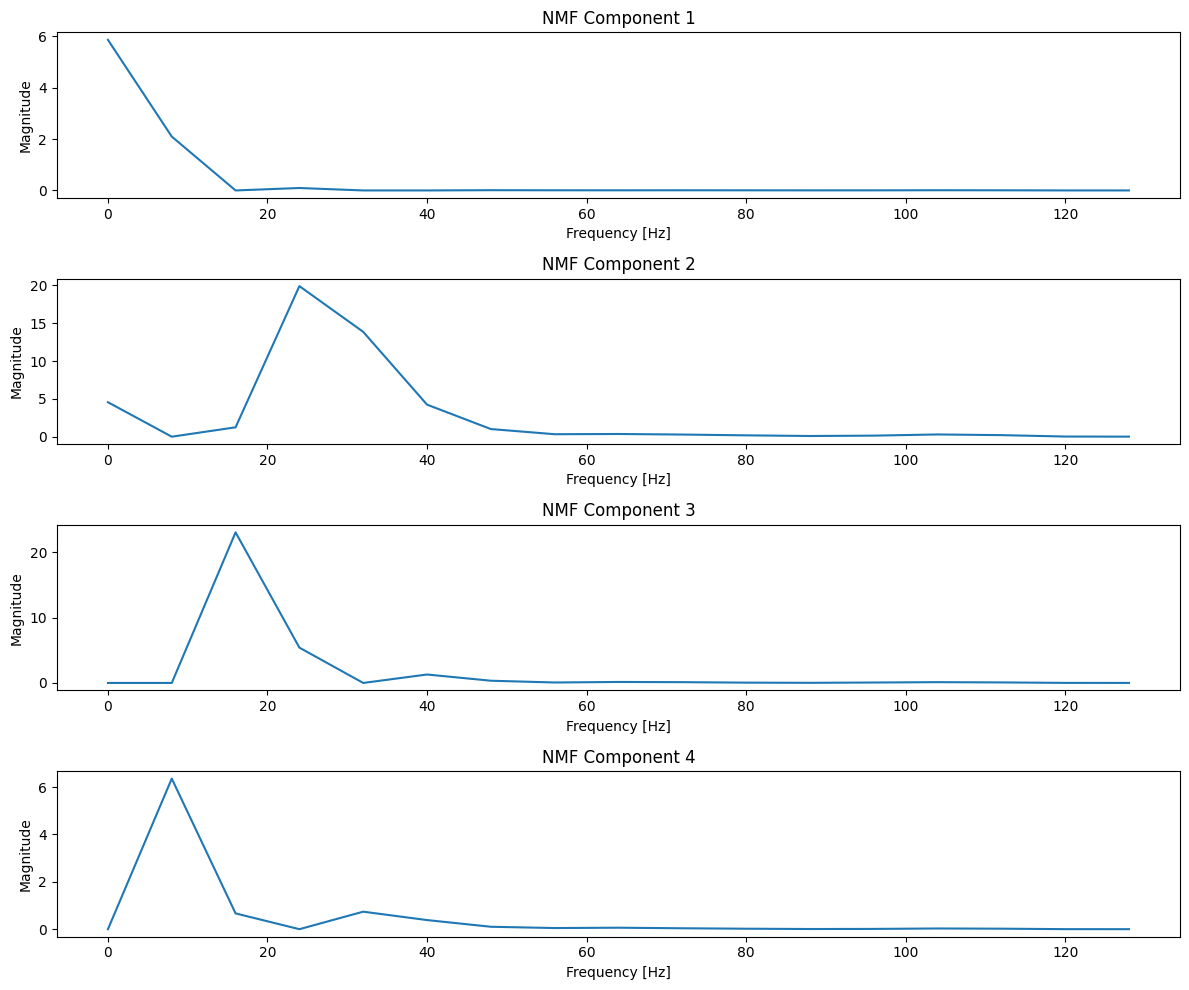

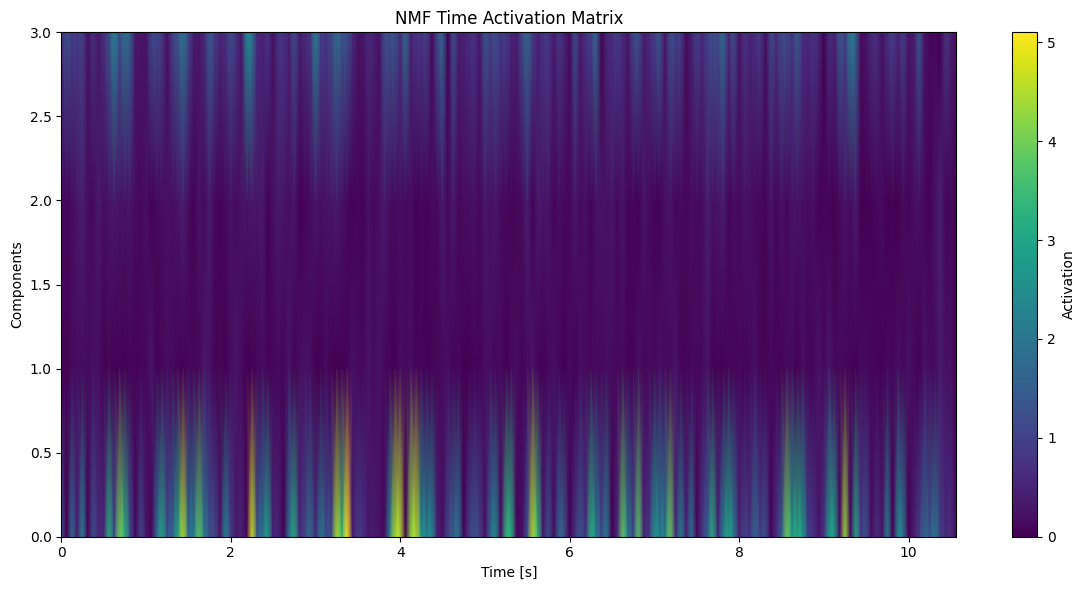

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from sklearn.decomposition import NMF

# Assuming 'channels_data' contains the EEG data for each channel
# and we have already loaded the data as in previous steps
first_channel_data = channels_data[0]
sampling_rate = 256  # Hz

# Parameters for STFT
window_size = 32  # Number of samples per window
overlap = 16  # Number of samples to overlap

# Compute STFT
f, t, Zxx = stft(first_channel_data, fs=sampling_rate, window='hann', nperseg=window_size, noverlap=overlap)
Zxx_magnitude = np.abs(Zxx)

# Apply NMF
n_components = 4  # Number of components
nmf = NMF(n_components=n_components, init='random', random_state=0)
W = nmf.fit_transform(Zxx_magnitude.T)
H = nmf.components_

# Plot the NMF components
plt.figure(figsize=(12, 10))

for i in range(n_components):
    plt.subplot(n_components, 1, i + 1)
    plt.plot(f, H[i, :])
    plt.title(f'NMF Component {i + 1}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

# Plot the time activation matrix W
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, np.arange(n_components), W.T, shading='gouraud')
plt.title('NMF Time Activation Matrix')
plt.ylabel('Components')
plt.xlabel('Time [s]')
plt.colorbar(label='Activation')
plt.tight_layout()
plt.show()


In [76]:
from scipy.signal import welch
import pywt

feature_list = ['mean', 'std', 'skew', 'kurt', 'delta_p', 'theta_p', 'alpha_p', 'beta_p', 'gamma_p']

def extract_features(eeg_data, fs):
    # Statistical features
    mean = np.mean(eeg_data)
    std = np.std(eeg_data)
    var = np.var(eeg_data)
    skewness = np.mean((eeg_data - mean) ** 3) / (std ** 3)
    kurtosis = np.mean((eeg_data - mean) ** 4) / (std ** 4) - 3

    # Frequency domain features using Welch method
    freqs, psd = welch(eeg_data, fs)
    delta_power = np.trapz(psd[(freqs >= 0.5) & (freqs <= 4)])
    theta_power = np.trapz(psd[(freqs >= 4) & (freqs <= 8)])
    alpha_power = np.trapz(psd[(freqs >= 8) & (freqs <= 13)])
    beta_power = np.trapz(psd[(freqs >= 13) & (freqs <= 30)])
    gamma_power = np.trapz(psd[(freqs >= 30) & (freqs <= 50)])

    # Time-frequency features using wavelet transform
    coeffs, _ = pywt.cwt(eeg_data, np.arange(1, 31), 'morl')
    wavelet_mean = np.mean(coeffs, axis=1)
    wavelet_std = np.std(coeffs, axis=1)

    features = [mean, std, var, skewness, kurtosis, delta_power, theta_power, alpha_power, beta_power, gamma_power]
    features.extend(wavelet_mean)
    features.extend(wavelet_std)

    return np.array(features), coeffs

In [49]:
channel = eeg_data['data']['data'][0]

## Accessing Electrode Level data for custom classification trials 

In [82]:
electrodes_to_use = ['PO3', 'PO4']

result = {}

channels = eeg_data['data']['data']

electrode_dict = {}

for idx, channel_name in enumerate(eeg_data['data']['channelNames']):
    electrode_dict[channel_name] = idx

for electrode in electrodes_to_use:
    channel = channels[electrode_dict[electrode]]
    features, coeffs = extract_features(channel, 256)
    result[electrode] = {'time-domain': channel, 'features': features}

print(result.keys(), '---> per-electode--->', result[list(result.keys())[0]].keys())

dict_keys(['PO3', 'PO4']) ---> per-electode---> dict_keys(['time-domain', 'features'])


### Understanding CWT data

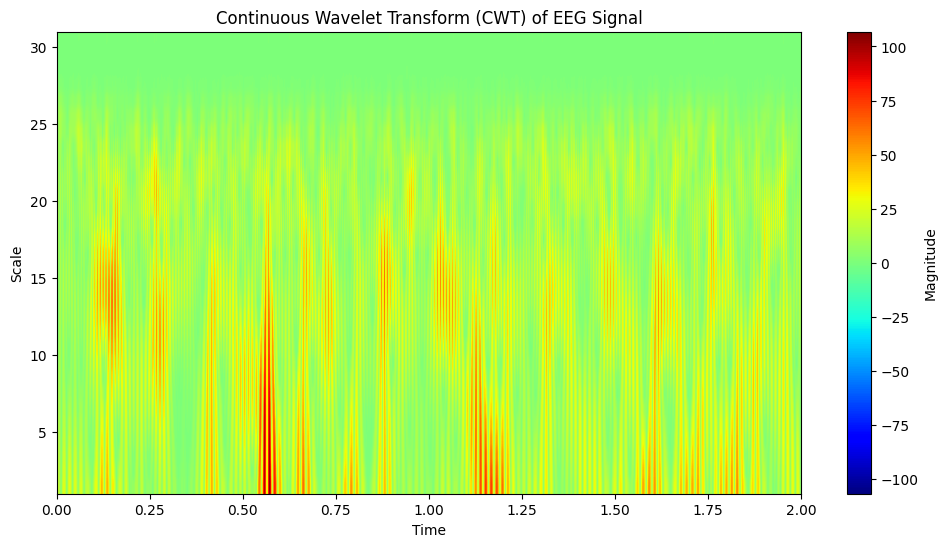

In [83]:
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(coeffs), extent=[0, len(eeg_data), 1, 31], cmap='jet', aspect='auto',
           vmax=np.abs(coeffs).max(), vmin=-np.abs(coeffs).max())
plt.colorbar(label='Magnitude')
plt.ylabel('Scale')
plt.xlabel('Time')
plt.title('Continuous Wavelet Transform (CWT) of EEG Signal')
plt.show()

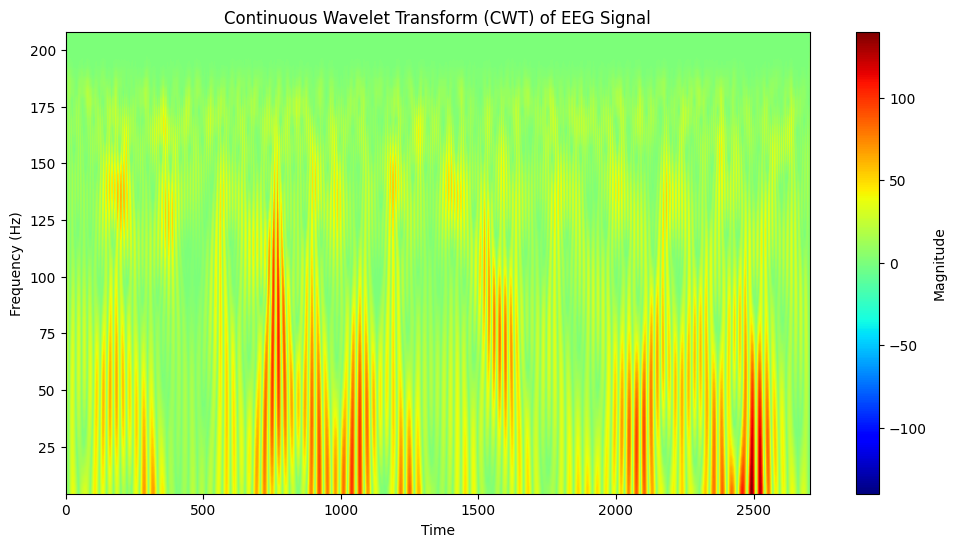

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Assuming eeg_data is your EEG signal and fs is the sampling frequency
fs = 256  # Sampling frequency in Hz
scales = np.arange(1, 50)  # Extend scales to 100 to capture lower frequencies

# Center frequency of the Morlet wavelet
f0 = pywt.central_frequency('morl')

# Convert scales to frequencies
frequencies = f0 * fs / scales

# Perform CWT with extended scales
coeffs, _ = pywt.cwt(channel, scales, 'morl')

# Plot the wavelet coefficients with frequencies on the y-axis
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(coeffs), extent=[0, len(channel), frequencies[-1], frequencies[0]], cmap='jet', aspect='auto',
           vmax=np.abs(coeffs).max(), vmin=-np.abs(coeffs).max())
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time')
plt.title('Continuous Wavelet Transform (CWT) of EEG Signal')
plt.show()